# Examine covid-19 variants

This examines covid-19 variants as originally aquired from <https://covid19.galaxyproject.org/genomics/4-Variation/>.

*Note:* This is being used to play around with data mining algorithms to see what we get. It's not necessarily the best way to process the data.

In [16]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import gzip

data = pd.read_csv('../original/variant_list.tsv.gz', sep="\t", low_memory=False)
print("%s rows x %s columns" % (data.shape[0], data.shape[1]))
data.head()

77121 rows x 14 columns


,Sample,CHROM,POS,REF,ALT,DP,AF,SB,DP4,EFF[*].IMPACT,EFF[*].FUNCLASS,EFF[*].EFFECT,EFF[*].GENE,EFF[*].CODON
0,SRR10903401,NC_045512,1409,C,T,126,0.039683,1,"67,54,2,3",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,Cat/Tat
1,SRR10903401,NC_045512,1821,G,A,93,0.096774,0,"48,36,5,4",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,gGt/gAt
2,SRR10903401,NC_045512,1895,G,A,106,0.037736,0,"51,51,2,2",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,Gta/Ata
3,SRR10903401,NC_045512,2407,G,T,123,0.024390,0,"57,63,1,2",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,aaG/aaT
4,SRR10903401,NC_045512,3379,A,G,121,0.024793,0,"56,62,1,2",LOW,SILENT,SYNONYMOUS_CODING,orf1ab,gtA/gtG


In [20]:
data['CHROM'].value_counts()

NC_045512    77121
Name: CHROM, dtype: int64

Great. Let's look at the distribution of the `AF` column (alternative frequencies).

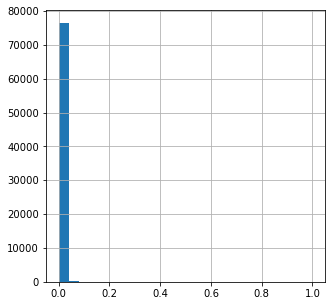

In [3]:
data['AF'].hist(figsize=(5,5), bins=25)

Hmmm... so almost all of the variants are low frequency (and maybe just errors). Let's look at higher frequency ones.

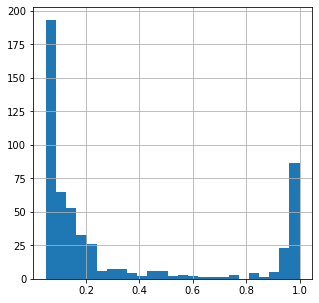

In [4]:
data[data['AF'] > 0.05]['AF'].hist(figsize=(5,5), bins=25)

Looks like a bit of a division between low and high (two peaks). What we'll do is split this data into two sets, the moderate frequency, and the ultra-low frequency (which may be mostly errors, but there's a lot more data there to apply data mining to).

Let's first create a new column with a variant ID to be used for later mining.

In [5]:
data['transaction_id'] = data.apply(
    lambda row: row.CHROM + ':' + row.REF + ':' + str(row.POS) + ':' + row.ALT, axis=1)
data

,Sample,CHROM,POS,REF,ALT,DP,AF,SB,DP4,EFF[*].IMPACT,EFF[*].FUNCLASS,EFF[*].EFFECT,EFF[*].GENE,EFF[*].CODON,transaction_id
0,SRR10903401,NC_045512,1409,C,T,126,0.039683,1,"67,54,2,3",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,Cat/Tat,NC_045512:C:1409:T
1,SRR10903401,NC_045512,1821,G,A,93,0.096774,0,"48,36,5,4",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,gGt/gAt,NC_045512:G:1821:A
2,SRR10903401,NC_045512,1895,G,A,106,0.037736,0,"51,51,2,2",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,Gta/Ata,NC_045512:G:1895:A
3,SRR10903401,NC_045512,2407,G,T,123,0.024390,0,"57,63,1,2",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,aaG/aaT,NC_045512:G:2407:T
4,SRR10903401,NC_045512,3379,A,G,121,0.024793,0,"56,62,1,2",LOW,SILENT,SYNONYMOUS_CODING,orf1ab,gtA/gtG,NC_045512:A:3379:G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77116,SRR11410528,NC_045512,17934,C,T,1249,0.056045,7,"433,744,20,51",LOW,SILENT,SYNONYMOUS_CODING,orf1ab,acC/acT,NC_045512:C:17934:T
77117,SRR11410528,NC_045512,23403,A,G,1684,0.988717,0,"0,0,380,1304",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,S,gAt/gGt,NC_045512:A:23403:G
77118,SRR11410528,NC_045512,25563,G,T,679,0.986745,0,"0,0,130,549",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,ORF3a,caG/caT,NC_045512:G:25563:T
77119,SRR11410528,NC_045512,26844,T,A,993,0.008056,35,"235,750,7,1",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,M,Tcc/Acc,NC_045512:T:26844:A


# Split into high and low frequency variants table

Let's split up this table into ultra-low, and moderate frequency variants (based on `AF` column).

In [6]:
data_mf = data[data['AF'] >= 0.05].copy()
data_ulf = data[data['AF'] < 0.05].copy()
print(f"Moderate frequency: {len(data_mf)}")
print(f"Ultra-low frequency: {len(data_ulf)}")

Moderate frequency: 542
Ultra-low frequency: 76579


We're going to first look at the low frequency variants.

# Define identifier of each transaction

The data is organized such that each genome name is an item, which are grouped into "transactions" based on the particular variant. We can group samples together based on shared SNVs (shared transaction IDs).

In [7]:
def group_transactions(df):
    f = df.groupby('transaction_id').agg(
        {'Sample': lambda x: set(x)}).reset_index().set_index('transaction_id')
    return pd.DataFrame(f['Sample'].values.tolist(), index=f.index)

transaction_table_mf = group_transactions(data_mf)
print(f"Size: {len(transaction_table_mf)}")
transaction_table_mf.head(5)

Size: 437


,0,1,2,3,4,5,6,7,8,9
transaction_id,,,,,,,,,,
NC_045512:A:10024:T,SRR11059942,None,None,None,None,None,None,None,None,None
NC_045512:A:10435:T,SRR11059942,None,None,None,None,None,None,None,None,None
NC_045512:A:10773:C,SRR11059943,None,None,None,None,None,None,None,None,None
NC_045512:A:10987:T,SRR11059942,None,None,None,None,None,None,None,None,None
NC_045512:A:11367:T,SRR10903402,SRR11059947,None,None,None,None,None,None,None,None


# Build binary matrix for R arules package

In [8]:
def build_binary_matrix(df):
    values_set = {u for v in df.values.tolist() for u in v}
    values_set.remove(None)
    values_list = sorted(list(values_set))
    
    binary_rows = []
    for index, row in df.iterrows():
        binary_row = [index]
        for value in values_list:
            binary_row.append(value in row.values)
        binary_rows.append(binary_row)
        
    values_list.insert(0,'index')
    
    return pd.DataFrame(binary_rows, columns = values_list).set_index('index')

transaction_table_mf_binary = build_binary_matrix(transaction_table_mf)
transaction_table_mf_binary

,SRR10903401,SRR10903402,SRR10971381,SRR11059940,SRR11059942,SRR11059943,SRR11059944,SRR11059945,SRR11059946,SRR11059947,...,SRR11409417,SRR11410528,SRR11410529,SRR11410532,SRR11410533,SRR11410536,SRR11410538,SRR11410540,SRR11410541,SRR11410542
index,,,,,,,,,,,,,,,,,,,,,
NC_045512:A:10024:T,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
NC_045512:A:10435:T,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
NC_045512:A:10773:C,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
NC_045512:A:10987:T,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
NC_045512:A:11367:T,False,True,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NC_045512:T:8335:C,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
NC_045512:T:8418:C,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
NC_045512:T:9429:C,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


## Transaction table ultra-low

Let's also define the table of ultra-low frequency variants.

In [10]:
transaction_table_ulf = group_transactions(data_ulf)
print(f"Size: {len(transaction_table_ulf)}")
transaction_table_ulf.head(5)

Size: 31503


,0,1,2,3,4,5,6,7,8,9,10
transaction_id,,,,,,,,,,,
NC_045512:A:10005:G,SRR11140748,SRR11177792,SRR11059946,SRR11059947,None,None,None,None,None,None,None
NC_045512:A:10014:G,SRR11177792,SRR11059947,None,None,None,None,None,None,None,None,None
NC_045512:A:10017:G,SRR11177792,SRR11059946,None,None,None,None,None,None,None,None,None
NC_045512:A:10017:T,SRR11409417,SRR11393704,None,None,None,None,None,None,None,None,None
NC_045512:A:10018:G,SRR11177792,None,None,None,None,None,None,None,None,None,None


In [12]:
transaction_table_ulf_binary = build_binary_matrix(transaction_table_ulf)
transaction_table_ulf_binary

,SRR10903401,SRR10903402,SRR10971381,SRR11059942,SRR11059943,SRR11059944,SRR11059945,SRR11059946,SRR11059947,SRR11140744,...,SRR11409417,SRR11410528,SRR11410529,SRR11410532,SRR11410533,SRR11410536,SRR11410538,SRR11410540,SRR11410541,SRR11410542
index,,,,,,,,,,,,,,,,,,,,,
NC_045512:A:10005:G,False,False,False,False,False,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
NC_045512:A:10014:G,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
NC_045512:A:10017:G,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
NC_045512:A:10017:T,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
NC_045512:A:10018:G,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NC_045512:T:998:C,False,False,False,False,False,False,False,True,True,True,...,False,False,False,False,False,False,False,False,False,False
NC_045512:T:9991:C,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
NC_045512:T:9995:A,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# Output variants table

Let's save the value of only data we are interested in so they can easily be loaded up later.

In [18]:
import csv

filename_mod = "moderate_frequency.tsv.gz"
transaction_table_mf_binary.to_csv(filename_mod, sep="\t", compression='gzip')
print(f"Wrote to file {filename_mod}")

filename_ulf = "ultra_low_frequency.tsv.gz"
transaction_table_ulf_binary.to_csv(filename_ulf, sep="\t", compression='gzip')
print(f"Wrote to file {filename_ulf}")

Wrote to file moderate_frequency.tsv.gz
Wrote to file ultra_low_frequency.tsv.gz


# Output SNV alignment

## Keep only high-frequency SNVs

We need to build an alignment, but there could be a mix of high/low frequency SNVs. We want to only keep the high-frequency SNVs.

In [29]:
data_hf = data_mf[data_mf['AF'] >= 0.8].copy()
data_hf

,Sample,CHROM,POS,REF,ALT,DP,AF,SB,DP4,EFF[*].IMPACT,EFF[*].FUNCLASS,EFF[*].EFFECT,EFF[*].GENE,EFF[*].CODON,transaction_id
381,SRR11059940,NC_045512,7866,G,T,54,0.944444,0,"2,1,26,25",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,gGt/gTt,NC_045512:G:7866:T
728,SRR11059942,NC_045512,10817,G,C,252,0.829365,6,"12,30,40,170",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,Gct/Cct,NC_045512:G:10817:C
1194,SRR11059942,NC_045512,26035,T,C,479,0.864301,4,"11,51,99,318",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,ORF3a,Tac/Cac,NC_045512:T:26035:C
1308,SRR11059943,NC_045512,2702,T,G,59,1.000000,0,"0,0,27,32",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,Ttc/Gtc,NC_045512:T:2702:G
1355,SRR11059943,NC_045512,8289,T,C,56,0.982143,0,"0,0,11,45",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,cTc/cCc,NC_045512:T:8289:C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77096,SRR11410528,NC_045512,1059,C,T,963,0.983385,0,"0,0,784,179",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,aCc/aTc,NC_045512:C:1059:T
77102,SRR11410528,NC_045512,3037,C,T,815,0.974233,0,"0,0,278,536",LOW,SILENT,SYNONYMOUS_CODING,orf1ab,ttC/ttT,NC_045512:C:3037:T
77114,SRR11410528,NC_045512,14408,C,T,1517,0.983520,0,"0,0,655,860",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,cCt/cTt,NC_045512:C:14408:T
77117,SRR11410528,NC_045512,23403,A,G,1684,0.988717,0,"0,0,380,1304",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,S,gAt/gGt,NC_045512:A:23403:G


In [73]:
data_mf[(data_mf['POS'] == 20240) & (data_mf['Sample'] == 'SRR11059942')].sort_values('AF', ascending=False)

,Sample,CHROM,POS,REF,ALT,DP,AF,SB,DP4,EFF[*].IMPACT,EFF[*].FUNCLASS,EFF[*].EFFECT,EFF[*].GENE,EFF[*].CODON,transaction_id
1051,SRR11059942,NC_045512,20240,G,A,752,0.111702,23,"159,429,11,73",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,aGt/aAt,NC_045512:G:20240:A
1052,SRR11059942,NC_045512,20240,G,C,752,0.105053,11,"159,429,14,66",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,aGt/aCt,NC_045512:G:20240:C


In [78]:
from Bio import AlignIO
from Bio.Alphabet import generic_dna
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment

def to_alignment(data):

    positions_list = sorted(data['POS'].value_counts().index.tolist())
    sample_list = sorted(data['Sample'].value_counts().index.tolist())

    sample_records = []
    for s in sample_list:
        seq_string = ''
        for p in positions_list:
            df_sample = data[(data['Sample'] == s) & (data['POS'] == p)]
            df_pos = data[data['POS'] == p]
            reference_list = df_pos['REF'].value_counts().index.tolist()
            
            if len(reference_list) != 1:
                raise Exception(f"Error for pos [{p}], reference list has {len(df_sample)} values")
                
            reference = reference_list[0]
            
            if len(df_sample) == 0:
                seq_string += reference
            elif len(df_sample) >= 1:
                alt = df_sample.sort_values('AF', ascending=False)['ALT'].iloc[0]
                seq_string += alt
                if len(df_sample) > 1:
                    print(f"Warning for sample:pos [{s}:{p}], length = {len(df_sample)} not 1")
                
        sample_records.append(SeqRecord(Seq(seq_string, generic_dna), id=s))

    return MultipleSeqAlignment(sample_records)
            
align_hf = to_alignment(data_hf)
print(align_hf)

DNAAlphabet() alignment with 34 rows and 51 columns
CCCGGCTCAGTTCCCATGGCCCTCCCACGTCTTGTCACGAAGTG...CGC SRR11059940
CCCGGCTCAGGTCCCATCGCCCTCCCACGTCTTGTCACGAAGCG...CGC SRR11059942
CCCGGCGCAGGCCCCCAGGCCCTCCCACGTCTTGCCACGAAGTG...CGC SRR11059943
CCCAGCTCAGGTCCCATGGCCCTCCCACGCCATGTCACGGAGTG...CGC SRR11059945
CCCGGCTCAGGTCCCATGGCCCTCTCACGTCTTGTCACGAAGTG...CGC SRR11140744
CCCGGCTCAGGTCCCATGGCCCTCTCACGTCTTGTCACGAAGTG...CGC SRR11140746
CCCGGCTCAGGTCCCATGGCCCTCTCACGTCTTGTCACGAAGTG...CGC SRR11140748
CCCGGCTCAGGTCCCATGGCCCTCTCACGTCTTGTCACGAAGTG...CGC SRR11140750
CCCGGCTCATGTCCCATGGCCCTCCCACGTCTTGTCACGAAGTG...CGC SRR11241254
CCCGGCTCAGGTCCCATGGCCCTCCCGCGTCTTGTCACGAAGTG...CGC SRR11241255
CCCGGCTCCGGTCCCATGGCCCTCCCACGTCTTGTCACGAAGTG...CGC SRR11247076
CCCGGCTCAGGTCCCATGGCCCTCCCATGTCTCGTCACGAAGTG...CGC SRR11247077
CCCGGCTCAGGTCCCATGGCCCTCCTGTGTCTTGTCACGAAGTG...CGC SRR11247078
TCCGGCTTAGGTCCCATGGTCCTCCCACGTTTTGTCGCGAAGTG...CGC SRR11314339
CCCGGCTCAGGTTCCATGGCCCTCCCATGTCTTGTCACGAAGTG...CGC SRR11393704
TCC

In [79]:
filename = "align_hf.phy"
with open(filename, "w") as output_handle:
    AlignIO.write(align_hf, output_handle, "phylip-relaxed")
    print(f"Wrote to {filename}")

Wrote to align_hf.phy


In [80]:
!head {filename}

 34 51
SRR11059940  CCCGGCTCAG TTCCCATGGC CCTCCCACGT CTTGTCACGA AGTGCCTTCG
SRR11059942  CCCGGCTCAG GTCCCATCGC CCTCCCACGT CTTGTCACGA AGCGCCTTCG
SRR11059943  CCCGGCGCAG GCCCCCAGGC CCTCCCACGT CTTGCCACGA AGTGCCTTCG
SRR11059945  CCCAGCTCAG GTCCCATGGC CCTCCCACGC CATGTCACGG AGTGCCTTCG
SRR11140744  CCCGGCTCAG GTCCCATGGC CCTCTCACGT CTTGTCACGA AGTGCCTTCG
SRR11140746  CCCGGCTCAG GTCCCATGGC CCTCTCACGT CTTGTCACGA AGTGCCTTCG
SRR11140748  CCCGGCTCAG GTCCCATGGC CCTCTCACGT CTTGTCACGA AGTGCCTTCG
SRR11140750  CCCGGCTCAG GTCCCATGGC CCTCTCACGT CTTGTCACGA AGTGCCTTCG
SRR11241254  CCCGGCTCAT GTCCCATGGC CCTCCCACGT CTTGTCACGA AGTGCCTTCG
